# Healthier tasty recipes recommender system

> The following notebook sumarizes the work that have been accomplished during the project and aims to present our results the more concisely possible. Minimal explanations are given regarding the datasets and mapping in order to understand the analysis that has been conducted during the third part of the project.

> In each part, we will indicate where one needs to go to get a more in-depth understanding.

In [1]:
# Imports

import sys
import json
import h5py
import tables
import inflect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import models

# Import our .py scripts

sys.path.insert(0, "/home/luke/Github/Project/python")
sys.path.insert(0, "../python")
sys.path.insert(1, "/Users/Lionel/Documents/Ada/Project/python")

import USDA_parsing as usda

/Users/Lionel/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def print_bold(str):
    print('\033[1m' + str + '\033[0m')

## 1. Preprocessing

### 1.1 Look at the raw data

#### Recipes from the Kaggle dataset

In [3]:
# Load raw data
kaggle_train_raw = json.load(open('../data/kaggle/train.json'))  
kaggle_test_raw = json.load(open('../data/kaggle/test.json'))
    
print("The length of the train set before any cleaning is: " + str(len(kaggle_train_raw)))
print("The length of the train set before any cleaning is: " + str(len(kaggle_test_raw)))
print_bold("Number of recipe in the Kaggle dataset before cleaning: " + str(len(kaggle_train_raw) + len(kaggle_test_raw)))

kaggle_train_raw[0]

The length of the train set before any cleaning is: 39774
The length of the train set before any cleaning is: 9944
Number of recipe in the Kaggle dataset before cleaning: 49718


{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

#### Recipes from the "From cookies to cooks" dataset

In [4]:
# Load raw data
cookies_to_cook_file = open("../data/recipeClean/ingredients.txt", mode='r', buffering=-1, encoding="ISO-8859-1", errors=None, newline=None, closefd=True, opener=None)
cookies_to_cook_raw = cookies_to_cook_file.readlines()

print_bold("Number of recipe in the \"From cookies to cooks\" dataset before cleaning: " + str(len(cookies_to_cook_raw)))

cookies_to_cook_raw[:1]

Number of recipe in the "From cookies to cooks" dataset before cleaning: 64249


['20f6f98261da097ba0b6fe4ba159b3c1.html\tbettycrocker.com\thttp://www.bettycrocker.com/recipes/wild-rice-soup/1ca76b2d-c859-4083-bfdd-9f4549267675\tWild Rice Soup\t2 tablespoons butter or margarine|2 medium stalks celery, sliced (1 cup)|1 medium carrot, coarsely shredded (1 cup)|1 medium onion, chopped (1/2 cup)|1 small green bell pepper, chopped (1/2 cup)|3 tablespoons Gold medalÂ® all-purpose flour|1/4 teaspoon pepper|1 pouch (from 10-ounce package) frozen cooked wild rice (1 1/4 cups)|1 cup water|1 can (10 1/2 ounces) condensed chicken broth|1 cup half-and-half|1/3 cup slivered almonds, toasted, if desired|1/4 cup chopped fresh parsley\n']

#### Recipes from the 1M dataset

In [5]:
# Load raw data

recipes_1m_raw = json.load(open("../data/1M/recipe1M_layers/layer1.json"))    

print_bold("Number of recipe in the 1M dataset before cleaning: " + str(len(recipes_1m_raw)))

recipes_1m_raw[:1]

Number of recipe in the 1M dataset before cleaning: 1029720


[{'id': '000018c8a5',
  'ingredients': [{'text': '6 ounces penne'},
   {'text': '2 cups Beechers Flagship Cheese Sauce (recipe follows)'},
   {'text': '1 ounce Cheddar, grated (1/4 cup)'},
   {'text': '1 ounce Gruyere cheese, grated (1/4 cup)'},
   {'text': '1/4 to 1/2 teaspoon chipotle chili powder (see Note)'},
   {'text': '1/4 cup (1/2 stick) unsalted butter'},
   {'text': '1/3 cup all-purpose flour'},
   {'text': '3 cups milk'},
   {'text': '14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)'},
   {'text': '2 ounces semisoft cheese (page 23), grated (1/2 cup)'},
   {'text': '1/2 teaspoon kosher salt'},
   {'text': '1/4 to 1/2 teaspoon chipotle chili powder'},
   {'text': '1/8 teaspoon garlic powder'},
   {'text': '(makes about 4 cups)'}],
  'instructions': [{'text': 'Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.'},
   {'text': 'Cook the penne 2 minutes less than package directions.'},
   {'text': '(It will finish cooking in the oven.)'},
   {'text': 'R

### 1.2 The cleaning procedure

The cleaning procedure allows us to have meaningful ingredient to use but also to standardize the ingredients from each dataset <br>

Summary of the procedure: <br>
- remove parenthesis and their content
- remove a set of special characters
- remove dangling letters
- remove the digits
- remove commas and everything that follow them
- remove a set of words considered as garbage (to_remove file)
- remove the adjectives (e.g. sliced, seared, ...)
- remove the alternative (everything that come after a 'or' is discarded)
- split ingredients that contains the word 'and' into two ingredients
- singularize every word


You can look into this procedure more in-depth either in the clean_recipes_datasets notebook or in the clean_recipes_datasets python script from which we use a few functions accross our scripts.

### 1.3 Look at the data after cleaning

#### Recipes from the Kaggle dataset

In [6]:
kaggle = json.load(open('../generated/clean_kaggle.json'))  
    
print("The length of the train set before any cleaning is: " + str(len(kaggle)))
print_bold("Number of recipe in the Kaggle dataset before cleaning: " + str(len(kaggle)))

kaggle[0]

The length of the train set before any cleaning is: 49718
Number of recipe in the Kaggle dataset before cleaning: 49718


['romaine lettuce',
 'black olife',
 'grape tomato',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo bean',
 'feta cheese']

> The structure of the JSON is changed to keep only the ingredients. The cleaning procedure has singularized each ingredient.

#### Recipes from the "From cookies to cooks" dataset

In [7]:
cookies_to_cooks = json.load(open('../generated/clean_cookies.json'))  
    
print("The length of the train set before any cleaning is: " + str(len(cookies_to_cooks)))
print_bold("Number of recipe in the Kaggle dataset before cleaning: " + str(len(cookies_to_cooks)))

cookies_to_cooks[0]

The length of the train set before any cleaning is: 47045
Number of recipe in the Kaggle dataset before cleaning: 47045


['butter',
 'stalks celery',
 'carrot',
 'onion',
 'green bell pepper',
 'gold medalâ® all-purpose flour',
 'pepper',
 'rice ',
 'water',
 'chicken broth',
 'half-and-half',
 'almond',
 'parsley']

> This dataset is the one that requires cleaning the most. After cleaning we lost 27% of the recipes

#### Recipes from the 1M dataset

In [8]:
one_m = json.load(open('../generated/clean_1m.json'))  
    
print("The length of the train set before any cleaning is: " + str(len(one_m)))
print_bold("Number of recipe in the Kaggle dataset before cleaning: " + str(len(one_m)))

one_m[0]

The length of the train set before any cleaning is: 869654
Number of recipe in the Kaggle dataset before cleaning: 869654


['elbow macaroni',
 'american cheese',
 'celery',
 'green pepper',
 'pimento',
 'mayonnaise',
 'vinegar',
 'salt',
 'dill weed']

> We lost 15% of the recipes from this dataset during the cleaning procedure

## 2. Data analysis

In [9]:
# We merge our three datasets into one
all_recipes = kaggle + cookies_to_cooks + one_m

#### 2.1 Number of ingredients per recipe

The maximum of ingredients in a recipe is: 99


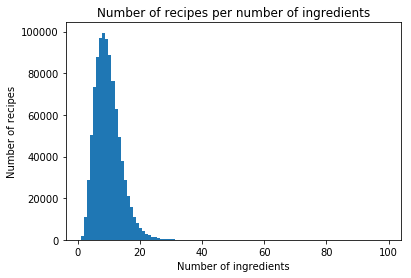

In [10]:
counts = list(map(lambda r: len(r),all_recipes))

counts = sorted(counts, reverse=True)
print('The maximum of ingredients in a recipe is: '+str(counts[0]))

plt.hist(counts, bins=100)
plt.title('Number of recipes per number of ingredients')
plt.xlabel('Number of ingredients')
plt.ylabel('Number of recipes')
plt.show()

#### 2.2 Number of unique ingredients

In [11]:
all_ingr = []
for r in all_recipes:
    for i in r:
        all_ingr.append(i)
        
df_recipe = pd.Series(all_ingr)

print('There are ' + str(len(df_recipe.unique())) + ' different ingredients')

There are 38182 different ingredients


> This is a huge number of ingredients, even considering our number of recipes. It is likely that a lot of ingredients are in fact some noise that we failed to filter during the parsing. To be sure we need to look at the distribution of the ingredients.

#### 2.3 Distribution of the ingredients

We search in the dataset the number of ingredients (x - ingredients) that appear a given number of times (y - occurences)

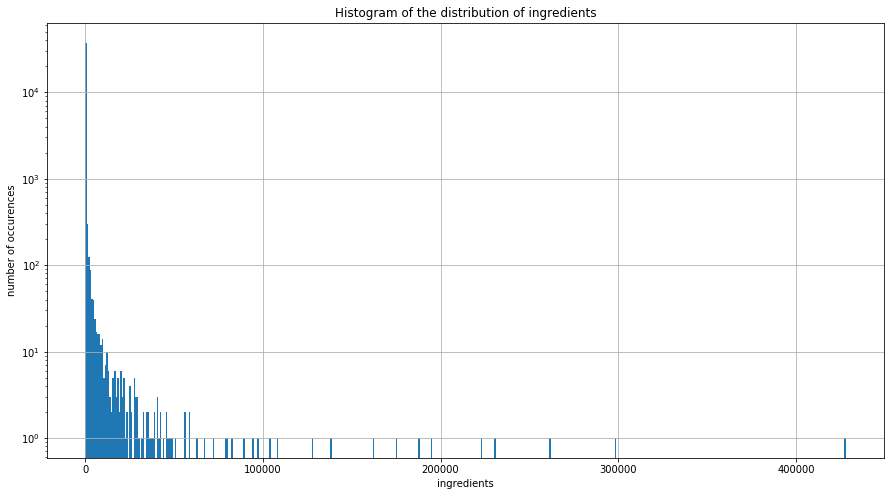

In [12]:
count_table = df_recipe.value_counts().to_frame().rename({0:'count'}, axis = 1)
ax = count_table['count'].hist(bins=500,figsize=(15, 8))
ax.set_yscale('log')
ax.set_title('Histogram of the distribution of ingredients')
ax.set_ylabel('number of occurences')
ax.set_xlabel('ingredients')
plt.show()

> There are more than 10 000 ingredients that appear only once.

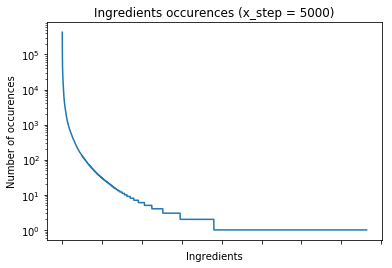

In [13]:
# Log scale

ax = count_table['count'].plot(logy=True)
ax.set_xlabel('Ingredients')
ax.set_ylabel('Number of occurences')
ax.set_title('Ingredients occurences (x_step = 5000)')
plt.show()

> Indeed, a lot of ingredients appear only a few times and we will not be able to extract some rules from them. Therefore, we decided to only keep the ignredients that appear in more than 15 recipes.

In [14]:
without_junk = count_table[count_table['count'] > 15]
print_bold("We keep "+ str(100*((without_junk['count'].sum()) / count_table.sum())[0])[:5]+\
      "% of the data if we discard ingredients that appear in less than 15 recipes.")

We keep 99.13% of the data if we discard ingredients that appear in less than 15 recipes.


## 3. USDA Mapping

#### 3.1 USDA database

> This section aims to give an insight on the work that has been done on the USDA mapping that is necessary for  the analysis conducted below. To get a more in-depth understanding, one can consult either the USDA_parsing notebook or the USDA_parsing (created to reuse functions from the notebook as below)

To get the nutrients of each recipes, our approach consists in linking the different ingredients of a recipe to an entry of the USDA database. As every ingredient does not match exactly the description of a USDA, we implemented a notion of score that indicates how well the ingredients match the entries of the database.

In [15]:
# Relevant data for USDA
food_des_path = "./../data/usda/FOOD_DES.txt"
food_groups_path = "./../data/usda/FD_GROUP.txt"
nut_data_path = "./../data/usda/NUT_DATA.txt"
nut_def_path = "./../data/usda/NUTR_DEF.txt"

all_paths = [food_des_path, food_groups_path, nut_data_path, nut_def_path]

In [16]:
# Generate singularization engine
engine = inflect.engine()

# Columns we want to retrieve from the database files
columns = ["food_id", "food_group_id", "long_description", "common_names"]
use_cols = [0, 1, 2, 4]

# Get the info from file
food_des = pd.read_csv(food_des_path, sep="^", encoding="ISO-8859-1", names=columns, usecols=use_cols, header=None)

# Display original table format
print_bold("original table format : ")
print(food_des.head())


# Generate search_words
food_des['search_words'] = food_des.apply(lambda row : usda.concat_common_and_des(usda.format_long_des(row['common_names'], engine),
                                                                                  usda.format_long_des(row['long_description'], engine)),
                                                                                  axis=1)

# Drop common_names column
food_des = food_des.drop("common_names", axis=1)
            
print_bold("\n\nnew table format")
food_des.head()

original table format : 
   food_id  food_group_id            long_description common_names
0     1001            100              Butter, salted          NaN
1     1002            100  Butter, whipped, with salt          NaN
2     1003            100       Butter oil, anhydrous          NaN
3     1004            100                Cheese, blue          NaN
4     1005            100               Cheese, brick          NaN


new table format


,food_id,food_group_id,long_description,search_words
0,1001,100,"Butter, salted","[butter, salted]"
1,1002,100,"Butter, whipped, with salt","[butter, whipped, salt]"
2,1003,100,"Butter oil, anhydrous","[butter, oil, anhydrou]"
3,1004,100,"Cheese, blue","[cheese, blue]"
4,1005,100,"Cheese, brick","[cheese, brick]"


> The original table format is an extract of the USDA database. As it is not likely we have an ingredient matching the long description, we generate from the long description a set of search words. Those words are obtained by splitting the sentence by words, singularizing them and removing,... The ones that give no information (e.g. "with"). This is what we can observe in the "new table format"

#### 3.2 Search function

In [17]:
def search_score(categories, ing_words) :
    # singularize search words
    ing_words = set([singularize_word(x) for x in ing_words])

    #prioritize matching query terms
    nb_matching = len(ing_words.intersection(set(categories)))

    #non_complexificators should not be penalized,ignore them AFTER computing number of matching words
    categories = [c for c in categories if (c not in non_complexificators)]


    #matching keywords one by one 
    matching = [len(set([x]).intersection(ing_words)) != 0 for x in categories]


    #first keywords are more important
    weights = np.linspace(2, 1, num=len(matching))
    weights = weights / sum(weights)

    #the query should have as many ingredients words as possible
    score = (10 * nb_matching) + sum([c[0] * c[1] for c in zip(matching, weights)])

    return score

>The design of the score function starts from three straightforward observations, namely :
- Lots of categories usually mean complex food item
- Categories are ordered by descending relevance
- Some categories (e.g ’raw’) do not make the food item more complex

>Note that the ’categories’ that do not make the food-item more complex were chosen empirically.

#### 3.3 Examples

In [18]:
# Raw categories
print(usda.search_ingredient('raw chicken', food_des, engine))
print(usda.search_ingredient('chicken', food_des, engine))

# Plurial word
print(usda.search_ingredient('fresh tomatoes', food_des, engine))

# Nationality categories
print(usda.search_ingredient('italian cheese', food_des, engine))

# Composite ingredients
print(usda.search_ingredient('pepper and salt', food_des, engine))

(      food_id            search_words  search_score
1043     5332  [chicken, ground, raw]     20.666667, 20.666666666666668)
(      food_id        search_words  search_score
7670    43128  [chicken, meatles]     10.666667, 10.666666666666666)
(      food_id           search_words  search_score
2928    11695  [tomato, orange, raw]     10.666667, 10.666666666666666)
(      food_id                                       search_words  search_score
7517    36055  [restaurant, italian, cheese, ravioli, marinar...     20.377778, 20.377777777777776)
(      food_id                                    search_words  search_score
2897    11632  [pepper, jalapeno, canned, solid, and, liquid]     20.355556, 20.355555555555554)


> As we can see:
- The word 'raw does not penalize the matching, even the opposite as it allows to match a entry of the USDA more exactly.
- Tomatoes can be mapped on tomato
- Words like nationalities can produce noises in the search_words, even so the most important word is in third place
- If two ingredients are given we can match the first one

#### 3.4 Final mapping

In [19]:
mapping_usda_id = json.load(open('../generated/ing_id_mapping.json'))  

mapping_usda_id['chicken']

43128

> The USDA_parsing notebook and script produce a ingredient mapping as a dictionary. The ingredient chicken is mapped on the USDA id 43128: [Chicken, meatless](https://ndb.nal.usda.gov/ndb/foods/show/43128?fgcd=&manu=&format=&count=&max=25&offset=&sort=default&order=asc&qlookup=43128&ds=&qt=&qp=&qa=&qn=&q=&ing=)

# Need to explain representative somewhere

## 3. Recommender

> This section shows the result of our recommender described in our [report]().

In [21]:
# Imports the generated files needed by the recommender

# Trained model that is used to compute the similirity between two ingredients
food_embeddings = models.Word2Vec.load('../generated/food_embeddings.bin')

# Dictionary to convert unit (e.g. cup) to an approximate value in gram
conver_gr = json.load(open('../generated/convert_gr.json'))
    
# Nutrients table
nutrients_mapping = pd.read_hdf("../generated/nut_data.h5", 'table')

# Map the id to its representative
id_repr = json.load(open("../generated/id_repr.json"))

# Map a representative to all its id
repr_ids = json.load(open("../generated/repr_ids.json"))

# Dictionary to convert unitary (e.g. 1 lemon) to an approximate value in gram
unit_quantities = json.load(open("../generated/1m_unit_quantities.json"))